In [37]:
import jax
import jax.numpy as jnp
import numpyro
import numpy as np
import blackjax
import numpyro.distributions as dist
import matplotlib.pyplot as plt
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer.reparam import LocScaleReparam
from numpyro.handlers import reparam
from jax.nn import sigmoid

rng_key = jax.random.PRNGKey(0) 

In [ ]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )

In [ ]:
def scatterplt(samples):
    fig, axes = plt.subplots(5, 2, figsize=(10, 12))
    axes = axes.flatten()
    # reparam_sample, mvn, mu_theta, std_theta = reparameterize_samples_dist(samples, best_c)
    # reparam_sample = reparam_sample if reparam else samples['theta'].T
    samples_theta = samples['theta_decentered'].T
    for i in range(10):
        axes[i].scatter(samples_theta[i], samples['tau'])
        axes[i].set_xlabel(f'x_{i}')
        axes[i].set_ylabel('log_std')

In [24]:
d = 500  # Specify the desired length
true_centeredness = jax.random.uniform(rng_key, shape=(d,))
print(true_centeredness)

[0.64603305 0.7639682  0.33023894 0.1361413  0.04565752 0.62201285
 0.91065145 0.96485317 0.9153786  0.14218664 0.98889816 0.351995
 0.15525901 0.62514865 0.20236754 0.6241003  0.7722124  0.04350173
 0.48393965 0.18258917 0.13864553 0.10276151 0.44638014 0.0421617
 0.436736   0.15286326 0.902513   0.64637434 0.8957244  0.35072005
 0.04517996 0.44102657 0.58418536 0.18096483 0.9091263  0.49038827
 0.89866304 0.8628422  0.46112025 0.11509669 0.8981048  0.45902145
 0.85552776 0.419896   0.7961445  0.8527545  0.7746123  0.756644
 0.0510242  0.8603283  0.36016774 0.27932477 0.6096262  0.19312036
 0.08921838 0.23534107 0.06103313 0.3878125  0.05479336 0.81688225
 0.62082446 0.4207387  0.2462678  0.7443981  0.5948837  0.6549374
 0.09061909 0.4572091  0.33331466 0.2401669  0.33904266 0.9025161
 0.7592008  0.11086249 0.68211377 0.96082544 0.11291647 0.47178364
 0.02752566 0.68644226 0.9239392  0.42203104 0.22489858 0.02585471
 0.3759253  0.80801153 0.51438653 0.08169985 0.5465164  0.996441
 0.6

In [25]:
def ll_pdf(centeredness, J, tau, mu, theta):
    return dist.Normal(jnp.full(J,mu*(1-centeredness)), jnp.exp(tau*(1-centeredness))).log_prob(theta) - dist.Normal(jnp.full(J,mu), jnp.exp(tau)).log_prob(theta)

In [26]:
def funnel(J=d, c = true_centeredness):
    mu = numpyro.sample('mu', dist.Normal(0, 1))
    tau = numpyro.sample('tau', dist.Normal(0,1))
    theta = numpyro.sample('theta', dist.Normal(jnp.full(J,mu), jnp.exp(tau)))
    numpyro.factor('theta_ll', ll_pdf(c, J, tau, mu, theta))

In [27]:
num_warmup = 1000

adapt = blackjax.window_adaptation(blackjax.nuts, funnel)
key = jax.random.PRNGKey(0)
(last_state, parameters), intermediate_states,logdensity_fn, calculated_centeredness  = adapt.run(key, num_warmup)
kernel = blackjax.nuts(logdensity_fn , **parameters).step

(500,)
centeredness [9.98773158e-01 6.18936062e-01 6.65211061e-04 5.29149652e-01
 3.77059072e-01 9.97573316e-01 3.68417591e-01 9.99920726e-01
 9.99967694e-01 1.17234886e-02 2.97355235e-01 9.99886513e-01
 7.68238127e-01 9.99742925e-01 9.92016315e-01 6.48054188e-09
 9.99669433e-01 2.17120081e-01 5.55507958e-01 9.99340713e-01
 1.27596839e-03 3.77815553e-07 5.81230342e-01 1.66801736e-04
 9.97295082e-01 7.98959300e-05 8.81611347e-01 9.93058681e-01
 9.80135560e-01 5.89194953e-01 5.49482480e-02 1.29923501e-04
 3.99556220e-01 1.15290924e-03 9.99447167e-01 2.14497140e-05
 2.64964113e-03 9.83412266e-01 8.47998890e-05 9.89084065e-01
 3.49740744e-01 2.82112628e-01 9.10333931e-01 5.73002219e-01
 1.40942400e-03 9.99694228e-01 7.04458356e-03 7.29814649e-01
 9.39321518e-01 5.07894787e-04 3.24224220e-06 6.21027291e-01
 9.97742295e-01 3.15739751e-01 7.63376713e-01 3.69178616e-02
 6.09477097e-03 9.99986053e-01 4.08510476e-01 1.00264223e-02
 8.83000672e-01 9.90240216e-01 7.12097099e-04 3.31889719e-01
 3.7

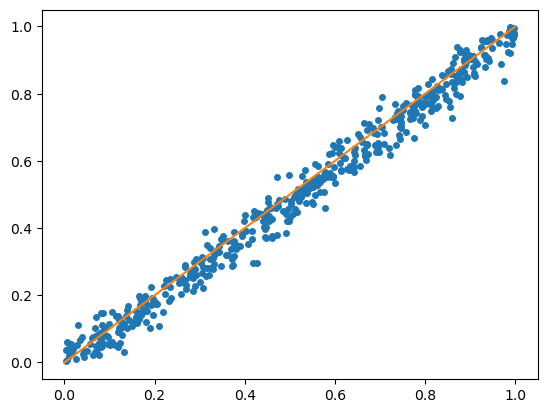

In [29]:
plt.plot(calculated_centeredness, true_centeredness, 'o', markersize=4)
plt.plot([0,1],[0,1])

In [31]:
num_sample = 1000

states, infos = inference_loop(key, kernel, last_state, num_sample)
_ = states.position["mu"].block_until_ready()

In [41]:
def ll_pdf(centeredness, J, tau, mu, theta):
    return dist.Normal(jnp.full(J,mu*(1-centeredness)), jnp.exp(tau*(1-centeredness))).log_prob(theta) - dist.Normal(jnp.full(J,mu), jnp.exp(tau)).log_prob(theta)

In [42]:
def funnel(J=d, c = true_centeredness):
    mu = numpyro.sample('mu', dist.Normal(0, 1))
    tau = numpyro.sample('tau', dist.Normal(0,1))
    with numpyro.handlers.reparam(numpyro.plate('J', J), config={'theta': LocScaleReparam(None)}):
        theta = numpyro.sample('theta', dist.Normal(mu,jnp.exp(tau)).expand([J]).to_event())
    numpyro.factor('theta_ll', ll_pdf(c, J, tau, mu, theta))

In [49]:
guide = AutoDiagonalNormal(funnel)
svi = SVI(funnel, guide, numpyro.optim.Adam(.0001), Trace_ELBO(1000))
params = svi.run(rng_key, 10000).params
params

100%|██████████| 10000/10000 [05:24<00:00, 30.79it/s, init loss: 1479.5670, avg. loss [9501-10000]: 460.9771]


{'auto_loc': Array([ 6.58015609e-02,  1.56938398e+00,  6.95166826e-01,  2.06821691e-03,
         8.28302443e-01,  1.51251387e-02,  1.78447310e-02,  5.13435015e-03,
         9.89467371e-05,  9.78898048e-01, -3.35841775e-01,  1.56561285e-02,
        -1.81467982e-03,  1.00370711e-02,  1.53172370e-02,  4.09294339e-03,
        -1.90742716e-01,  2.46970400e-01,  6.90734982e-01, -6.59784436e-01,
         3.16827279e-03,  1.46925058e-02,  1.48493955e-02, -6.29003823e-01,
        -3.90782654e-01, -2.96294183e-01,  4.25402552e-01,  8.36851895e-01,
        -7.84670934e-04, -6.57546744e-02, -5.83172143e-01,  1.51723653e-01,
        -7.40877865e-03,  8.73715989e-03,  5.92480004e-01,  1.42122861e-02,
         7.43273795e-02, -3.09824109e-01, -6.82838261e-04, -1.07258904e+00,
        -5.75248957e-01, -5.20551503e-01, -1.78376555e-01,  9.51151177e-03,
         6.87381625e-01, -7.65360966e-02, -2.66943425e-01, -4.79928654e-04,
         1.89199850e-01,  5.23804803e-04,  1.65938027e-02, -1.44315645e-01,


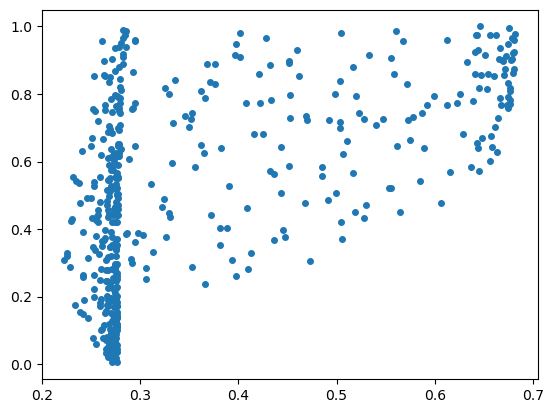

In [50]:
plt.plot(params['theta_centered'], true_centeredness, 'o', markersize=4)